In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")

# extrapolation

In [8]:
df_scfa = pd.read_excel('../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[df_scfa_meta.Diet=='Inulin']
df_scfa_meta.head()

Vendors = ['Beijing','Guangdong','Hunan','Shanghai']
for idx,directory in enumerate(['leave_BJ_out','leave_GD_out','leave_HN_out','leave_SH_out']):
    vendor = Vendors[idx]
    df_16S = pd.read_excel('../../../../data/16S_absolute_abundance.xlsx', index_col=0)
    df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
    df_X = pd.read_csv('extrapolation/%s/top40_absab/independent_variables_top40.csv'%(directory), index_col=0)
    df_16S = df_16S[df_X.columns]
    df_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
    df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'
    df_meta = df_meta.loc[df_scfa_meta.index]
    df_16S_meta = pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
    df_16S_meta = df_16S_meta[df_16S_meta.Diet=='Inulin']
    df_opt_paras = pd.read_excel('extrapolation/%s/top40_absab/optimal_rf_hyperparameters_top40.xlsx'%(directory), index_col=0)
    df_Y = pd.read_csv('extrapolation/%s/top40_absab/response_variables_scfa_deriv.csv'%(directory), index_col=0)

    df_res = None
    for scfa in ['Acetate','Butyrate','Propionate']:
        dydt = np.asarray(list(df_Y[scfa]))
        X = np.asarray(df_X.values)
        regr = RandomForestRegressor(
            random_state=0,
            bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
            max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
            max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
            min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
            min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
            n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
            n_jobs=-1
        )
        clf = regr.fit(X, dydt)
        curr_X = df_16S_meta.iloc[:,4:].values
        pred_Y = regr.predict(curr_X)
        curr_df = df_16S_meta.iloc[:,[0,1,2,3]]
        curr_df['SCFA'] = scfa
        curr_df['Deriv'] = pred_Y
        curr_df = curr_df[curr_df.Vendor==vendor]
        if df_res is None:
            df_res = curr_df
        else:
            df_res = pd.concat([df_res, curr_df])
    
    lines = []
    for curr_vendor in list(set(df_res.Vendor)):
        all_mice = list(set(df_res.loc[df_res.Vendor==curr_vendor,'MiceID']))
        for curr_mice in all_mice:
            for scfa in ['Acetate','Butyrate','Propionate']:
                curr_df = df_res[(df_res.MiceID==curr_mice)&(df_res.SCFA==scfa)].sort_values(by='Day')
                cs = CubicSpline(curr_df.Day, curr_df.Deriv)
                day0_observed = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==0),scfa].values[0]
                day0_simulated = day0_observed 
                lines.append([curr_mice, curr_vendor, 0, scfa, day0_observed, day0_simulated])
                for day in np.arange(1,32):
                    observed_value = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==day),scfa]
                    if len(observed_value) == 0:
                        lines.append([curr_mice, curr_vendor, day, scfa, np.NaN, day0_simulated+cs.integrate(0,day)])
                    else:
                        observed_value = observed_value.values[0] 
                        lines.append([curr_mice, curr_vendor, day, scfa, observed_value, day0_simulated+cs.integrate(0,day)])
    df_extra = pd.DataFrame(lines, columns=['MiceID','Vendor','Day','SCFA','Observed','Predicted'])

In [9]:
df_extra.head()

,MiceID,Vendor,Day,SCFA,Observed,Predicted
0,SI5,Shanghai,0,Acetate,10.290783,10.290783
1,SI5,Shanghai,1,Acetate,NaN,15.449751
2,SI5,Shanghai,2,Acetate,19.725804,17.582575
3,SI5,Shanghai,3,Acetate,NaN,18.378718
4,SI5,Shanghai,4,Acetate,NaN,18.973624


# Intrapolation

In [11]:
for idx,directory in enumerate(['leave_group1_out','leave_group2_out','leave_group3_out','leave_group4_out']):
    df_16S = pd.read_excel('../../../../data/16S_absolute_abundance.xlsx', index_col=0)
    df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
    df_X = pd.read_csv('intrapolation/%s/top40_absab/independent_variables_top40.csv'%(directory), index_col=0)
    df_16S = df_16S[df_X.columns]
    df_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
    df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'
    df_meta = df_meta.loc[df_scfa_meta.index]
    df_16S_meta = pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
    df_16S_meta = df_16S_meta[df_16S_meta.Diet=='Inulin']
    df_opt_paras = pd.read_excel('intrapolation/%s/top40_absab/optimal_rf_hyperparameters_top40.xlsx'%(directory), index_col=0)
    df_Y = pd.read_csv('intrapolation/%s/top40_absab/response_variables_scfa_deriv.csv'%(directory), index_col=0)

    df_res = None
    for scfa in ['Acetate','Butyrate','Propionate']:
        dydt = np.asarray(list(df_Y[scfa]))
        X = np.asarray(df_X.values)
        regr = RandomForestRegressor(
            random_state=0,
            bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
            max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
            max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
            min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
            min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
            n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
            n_jobs=-1
        )
        clf = regr.fit(X, dydt)
        curr_X = df_16S_meta.iloc[:,4:].values
        pred_Y = regr.predict(curr_X)
        curr_df = df_16S_meta.iloc[:,[0,1,2,3]]
        curr_df['SCFA'] = scfa
        curr_df['Deriv'] = pred_Y
        curr_df = curr_df[curr_df.MiceID.str.contains(str(idx+1))]
        if df_res is None:
            df_res = curr_df
        else:
            df_res = pd.concat([df_res, curr_df])
    
    lines = []
    for curr_vendor in list(set(df_res.Vendor)):
        all_mice = list(set(df_res.loc[df_res.Vendor==curr_vendor,'MiceID']))
        for curr_mice in all_mice:
            for scfa in ['Acetate','Butyrate','Propionate']:
                curr_df = df_res[(df_res.MiceID==curr_mice)&(df_res.SCFA==scfa)].sort_values(by='Day')
                cs = CubicSpline(curr_df.Day, curr_df.Deriv)
                day0_observed = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==0),scfa].values[0]
                day0_simulated = day0_observed 
                lines.append([curr_mice, curr_vendor, 0, scfa, day0_observed, day0_simulated])
                for day in np.arange(1,32):
                    observed_value = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==day),scfa]
                    if len(observed_value) == 0:
                        lines.append([curr_mice, curr_vendor, day, scfa, np.NaN, day0_simulated+cs.integrate(0,day)])
                    else:
                        observed_value = observed_value.values[0] 
                        lines.append([curr_mice, curr_vendor, day, scfa, observed_value, day0_simulated+cs.integrate(0,day)])
    df_intra = pd.DataFrame(lines, columns=['MiceID','Vendor','Day','SCFA','Observed','Predicted'])

In [12]:
df_intra.head()

,MiceID,Vendor,Day,SCFA,Observed,Predicted
0,SI4,Shanghai,0,Acetate,7.917183,7.917183
1,SI4,Shanghai,1,Acetate,NaN,13.451260
2,SI4,Shanghai,2,Acetate,24.846791,16.205460
3,SI4,Shanghai,3,Acetate,NaN,17.769333
4,SI4,Shanghai,4,Acetate,NaN,19.130607


# Compare prediction error

In [16]:
df_intra = df_intra.dropna()
df_intra['PredictionType'] = 'Interpolation'
df_intra['Diff'] = df_intra['Predicted']-df_intra['Observed']
df_extra = df_extra.dropna()
df_extra['PredictionType'] = 'Extrapolation'
df_extra['Diff'] = df_extra['Predicted']-df_extra['Observed']
df_combined = pd.concat([df_intra, df_extra], ignore_index=True)
df_combined.head()

,MiceID,Vendor,Day,SCFA,Observed,Predicted,PredictionType,Diff
0,SI4,Shanghai,0,Acetate,7.917183,7.917183,Interpolation,0.000000
1,SI4,Shanghai,2,Acetate,24.846791,16.205460,Interpolation,-8.641331
2,SI4,Shanghai,5,Acetate,15.462615,20.675185,Interpolation,5.212569
3,SI4,Shanghai,10,Acetate,33.256440,22.513624,Interpolation,-10.742817
4,SI4,Shanghai,13,Acetate,9.274994,17.639918,Interpolation,8.364923


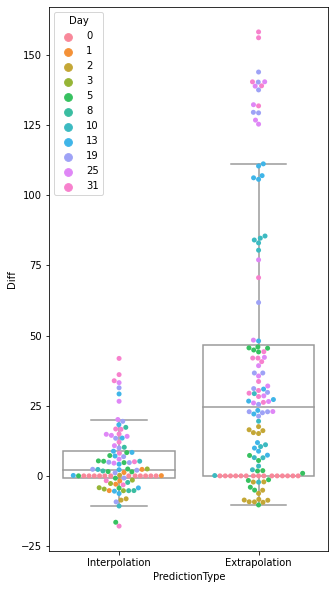

In [27]:
fig,ax=plt.subplots(figsize=(5,10))
sns.boxplot(x='PredictionType', y='Diff', data=df_combined, showfliers = False, color='w')
sns.swarmplot(x='PredictionType', y='Diff', hue='Day', data=df_combined)